In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

base_path = os.getcwd()+ '/FutureSales/data/competitive-data-science-predict-future-sales'

In [2]:
train_file_path= base_path+'/sales_train.csv'
items_file_path = base_path+'/items.csv'
item_category_path = base_path + '/item_categories.csv'

sales_train = pd.read_csv(train_file_path)
print('train data dim : {}'.format(sales_train.shape))


train data dim : (2935849, 6)


In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
# date_block_num, item_cnt_day col에 대해 알아야 하겠다.
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


<AxesSubplot:>

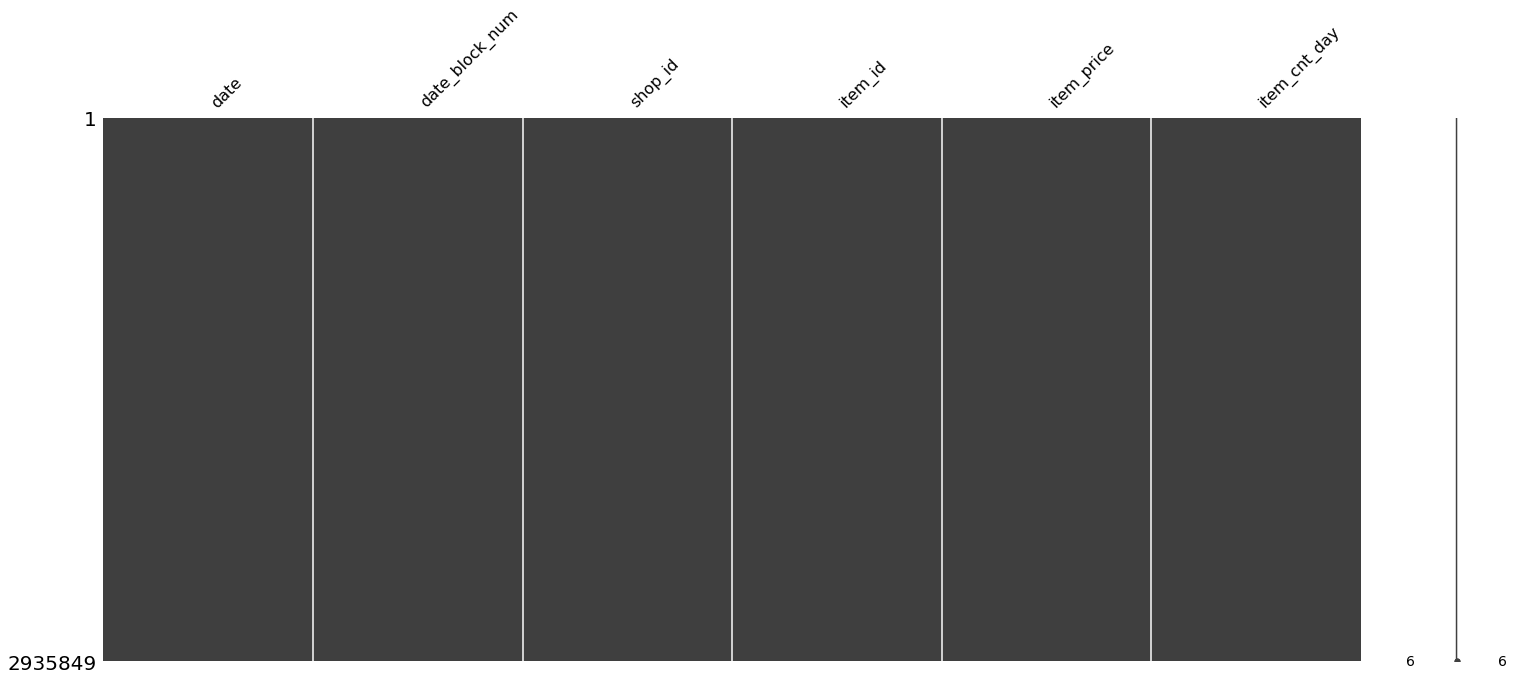

In [6]:
msno.matrix(sales_train)

In [7]:
for c in sales_train.columns:
    print('{} : {}'.format(c, len(sales_train.loc[pd.isnull(sales_train[c]), c].values)))

date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [12]:
# academic한 dataset이라 그런지 결측치는 없음을 확인
# 계절에 따른 판매량의 패턴이 있는지 파악하기 위한 작업을 해본다.
monthly_sales_item = sales_train.groupby(['date_block_num', 'item_id'])
monthly_sales_item.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935830,11.10.2015,33,25,7286,299.00,1.0
2935831,22.10.2015,33,25,7187,299.00,1.0
2935832,26.10.2015,33,25,7484,299.00,1.0
2935834,29.10.2015,33,25,7235,298.00,1.0


In [15]:
monthly_sales_item_withshop = sales_train.groupby(['date_block_num', 'shop_id','item_id'])['item_cnt_day'].sum()
monthly_sales_item_withshop

date_block_num  shop_id  item_id
0               0        32         6.0
                         33         3.0
                         35         1.0
                         43         1.0
                         51         2.0
                                   ... 
33              59       22087      6.0
                         22088      2.0
                         22091      1.0
                         22100      1.0
                         22102      1.0
Name: item_cnt_day, Length: 1609124, dtype: float64

In [16]:
monthly_sales_item_withshop = sales_train.groupby(['shop_id', 'item_id','date_block_num'])['item_cnt_day'].sum()
monthly_sales_item_withshop

shop_id  item_id  date_block_num
0        30       1                 31.0
         31       1                 11.0
         32       0                  6.0
                  1                 10.0
         33       0                  3.0
                                    ... 
59       22164    27                 2.0
                  30                 1.0
         22167    9                  1.0
                  11                 2.0
                  17                 1.0
Name: item_cnt_day, Length: 1609124, dtype: float64

In [17]:
monthly_sales_item_withshop['month'] = monthly_sales_item_withshop['date_block_num'].map(lambda x: (x % 12) + 1)
monthly_sales_item_withshop['year'] = monthly_sales_item_withshop['date_block_num'].map(lambda x: 2013 + x // 12)
monthly_sales_item_withshop

KeyError: 'date_block_num'